# Load libs

In [1]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and describe

In [2]:
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

# Preprocessing dataset

## Check for NaN

In [4]:
df_na_sum = df.isna().sum()
df_na_sum[df_na_sum > 0]/len(df)

car                     0.991485
Bar                     0.008436
CoffeeHouse             0.017108
CarryAway               0.011905
RestaurantLessThan20    0.010249
Restaurant20To50        0.014901
dtype: float64

## Drop `car` column since it has 99% `NaN`

In [5]:
df.drop('car', axis=1, inplace=True)
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

## Drop `NaN` in `CarryAway` and `RestaurantLessThan20` since it doesn't allow `NaN` and it takes small percent of dataset

In [7]:
df.dropna(subset=["CarryAway", "RestaurantLessThan20"], inplace=True)
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
22,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
23,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
24,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
25,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,1,0,0,1,0
26,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12445 entries, 22 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12445 non-null  object
 1   passanger             12445 non-null  object
 2   weather               12445 non-null  object
 3   temperature           12445 non-null  int64 
 4   time                  12445 non-null  object
 5   coupon                12445 non-null  object
 6   expiration            12445 non-null  object
 7   gender                12445 non-null  object
 8   age                   12445 non-null  object
 9   maritalStatus         12445 non-null  object
 10  has_children          12445 non-null  int64 
 11  education             12445 non-null  object
 12  occupation            12445 non-null  object
 13  income                12445 non-null  object
 14  Bar                   12380 non-null  object
 15  CoffeeHouse           12270 non-nul

## Change all **object** columns to **category**

In [9]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12445 entries, 22 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12445 non-null  category
 1   passanger             12445 non-null  category
 2   weather               12445 non-null  category
 3   temperature           12445 non-null  int64   
 4   time                  12445 non-null  category
 5   coupon                12445 non-null  category
 6   expiration            12445 non-null  category
 7   gender                12445 non-null  category
 8   age                   12445 non-null  category
 9   maritalStatus         12445 non-null  category
 10  has_children          12445 non-null  int64   
 11  education             12445 non-null  category
 12  occupation            12445 non-null  category
 13  income                12445 non-null  category
 14  Bar                   12380 non-null  category
 15  C

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12445 entries, 22 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   destination           12445 non-null  category
 1   passanger             12445 non-null  category
 2   weather               12445 non-null  category
 3   temperature           12445 non-null  int64   
 4   time                  12445 non-null  category
 5   coupon                12445 non-null  category
 6   expiration            12445 non-null  category
 7   gender                12445 non-null  category
 8   age                   12445 non-null  category
 9   maritalStatus         12445 non-null  category
 10  has_children          12445 non-null  int64   
 11  education             12445 non-null  category
 12  occupation            12445 non-null  category
 13  income                12445 non-null  category
 14  Bar                   12380 non-null  category
 15  C

## Visualize dataset

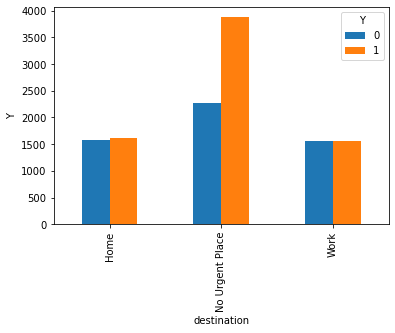

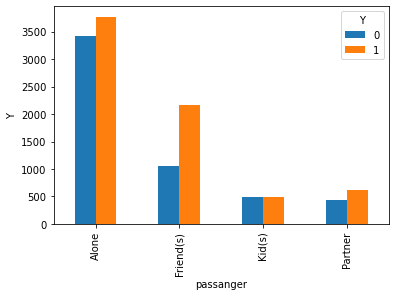

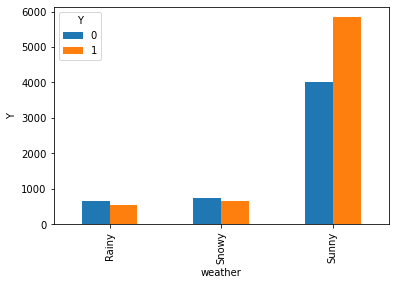

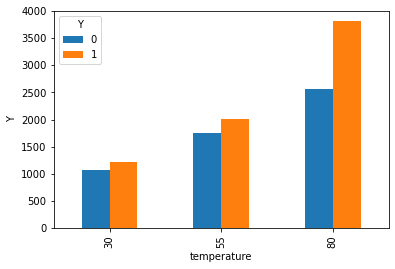

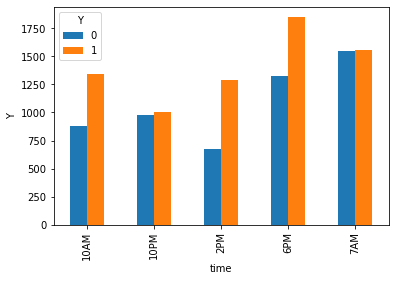

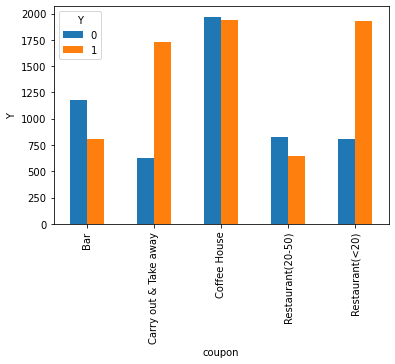

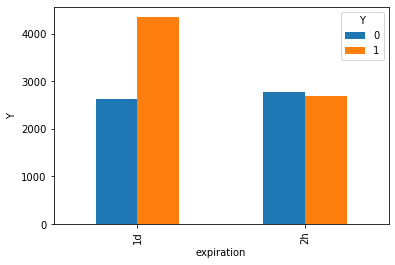

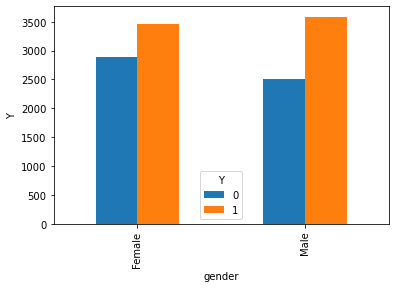

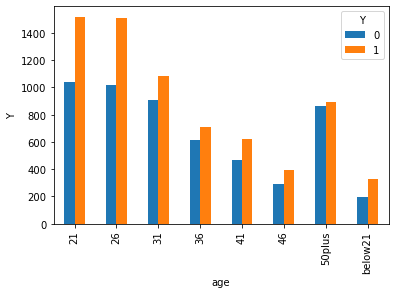

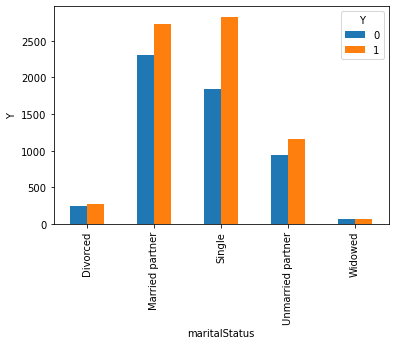

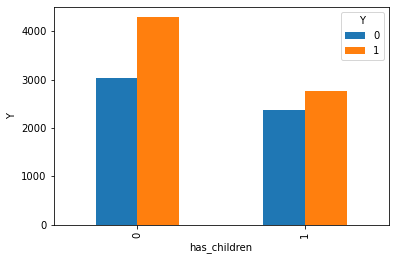

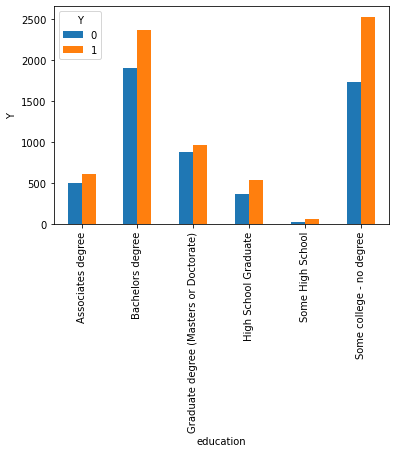

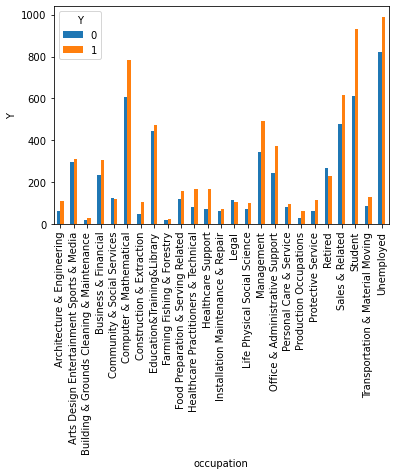

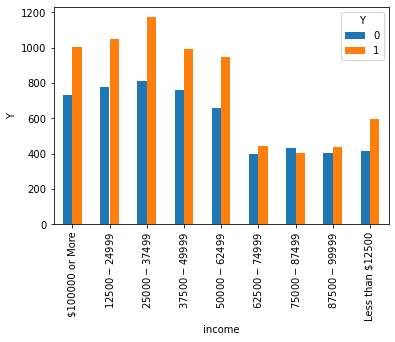

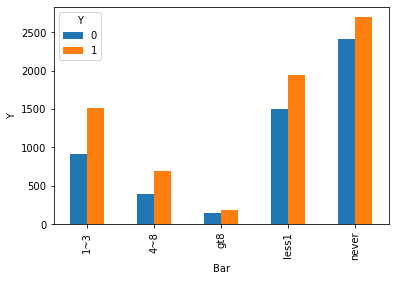

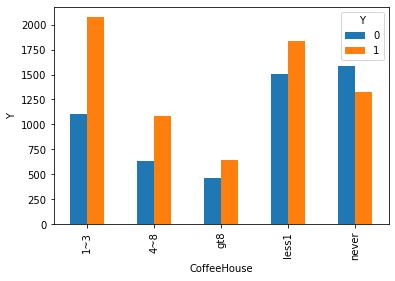

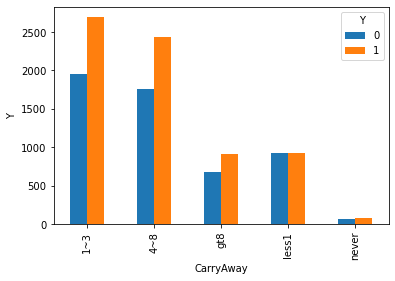

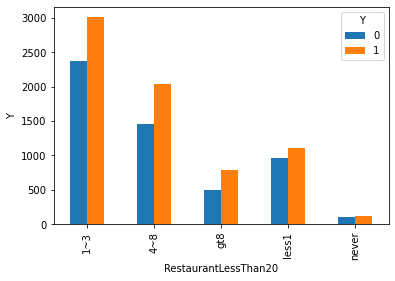

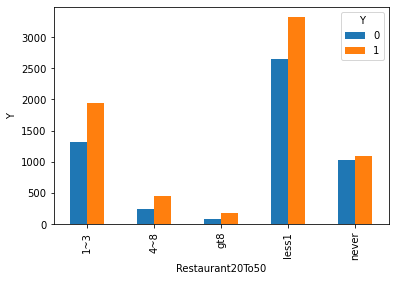

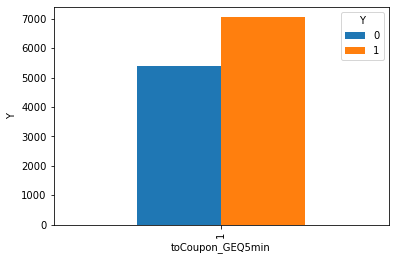

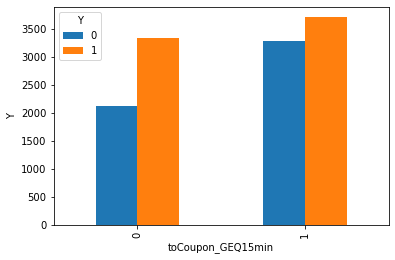

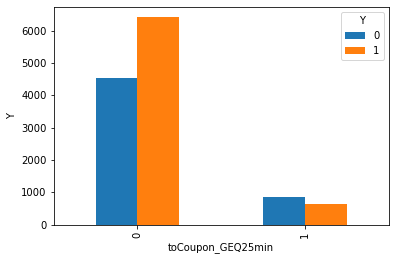

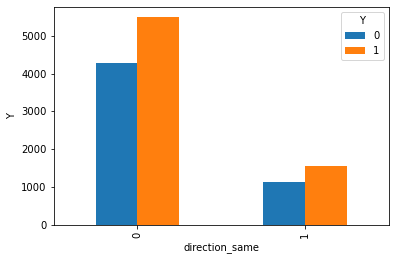

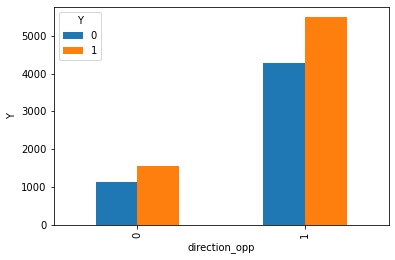

In [11]:
for col in df.drop('Y', axis=1).columns:
    pd.crosstab(df[col], df['Y']).plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Y')
    plt.show()

## Check if dataset is balanced

In [12]:
df["Y"].value_counts(normalize=True)

1    0.566412
0    0.433588
Name: Y, dtype: float64

# Value encoding

In [13]:
df.dtypes

destination             category
passanger               category
weather                 category
temperature                int64
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [14]:
x = df.drop('Y', axis=1)
y = df['Y']

ohe = OneHotEncoder(sparse=False)
x = pd.DataFrame(ohe.fit_transform(x), index=y.index, columns=ohe.get_feature_names(x.columns))

# Split data for train and test (k-fold)

In [15]:
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

## Random Forest classifier

In [16]:
rfc = RandomForestClassifier()

rfc_acc = 0
rfc_cfm = np.zeros((2, 2))

for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    rfc_acc = rfc_acc + accuracy_score(y_test, y_pred)
    rfc_cfm = rfc_cfm + confusion_matrix(y_test, y_pred)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12439 12441 12442] TEST: [    1     2     8 ... 12440 12443 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    24    27 ... 12425 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    14 ... 12417 12423 12439]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    11 ... 12433 12434 12441]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    3     7    10 ... 12428 12432 12442]
Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.70      0.72      1080
           1       0.78      0.82      0.80      1409

    accuracy                           0.77      2489
   macro avg       0.76      0.76      0.76      2489
weighted avg       0.77      0.77      0.77      2489



# Accuracy and Mean Score 

In [17]:
from sklearn.model_selection import cross_val_score
rfc = RandomForestClassifier()
score=cross_val_score(rfc,x,y,cv=5)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))

Average Cross Validation score :0.6863800723182001
standard deviation of results :0.016556732661392713


## Average accuracy score

In [18]:
rfc_acc/kf.get_n_splits()

0.7595018079550021

## Combine confusion matrix

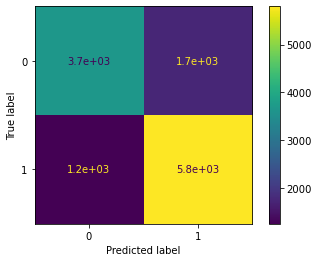

In [19]:
ConfusionMatrixDisplay(rfc_cfm).plot()
plt.show()

# Splitting the data into train and test set

# Best Hyperparameter With max_depth=2, random_state=0

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
rfc = RandomForestClassifier(max_depth=2, random_state=0)
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

# Best parameter for Random Forest

In [47]:
print(clf.best_params_)

{'max_depth': 14, 'max_features': 9}


# Accuracy and Mean score for Random Forest

In [23]:
score=cross_val_score(rfc,x,y,cv=10)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))

Average Cross Validation score :0.5812772633944137
standard deviation of results :0.009696025690697021


# Confusion Matrix For Random Forest

In [71]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
rfc = RandomForestClassifier(max_depth=2, random_state=0)
for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12441 12442 12444] TEST: [    1     2     8 ... 12435 12438 12443]
TRAIN: [    0     1     2 ... 12441 12442 12443] TEST: [    9    13    15 ... 12436 12440 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    27    34 ... 12394 12418 12425]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   24    46    47 ... 12419 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    45 ... 12416 12417 12423]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   14    19    20 ... 12402 12415 12439]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   11    25    40 ... 12421 12430 12441]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    21 ... 12424 12433 12434]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    3    10    16 ... 12405 12427 12432]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    7    36    42 ... 12422 12428 12442]
Classification Report: 
      

# RandomForestClassifier(max_depth=5, random_state=1)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
rfc = RandomForestClassifier(max_depth=5, random_state=1)
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=5, random_state=1),
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

# Best parameter For Random Forest 

In [38]:
print(clf.best_params_)

{'max_depth': 14, 'max_features': 13}


# Accuracy and Mean score for Random Forest

In [39]:
score=cross_val_score(rfc,x,y,cv=10)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))

Average Cross Validation score :0.6657302521985047
standard deviation of results :0.012316138811289637


# Confusion Matrix For Random Forest 

In [72]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
rfc = RandomForestClassifier(max_depth=5, random_state=1)
for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12441 12442 12444] TEST: [    1     2     8 ... 12435 12438 12443]
TRAIN: [    0     1     2 ... 12441 12442 12443] TEST: [    9    13    15 ... 12436 12440 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    27    34 ... 12394 12418 12425]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   24    46    47 ... 12419 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    45 ... 12416 12417 12423]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   14    19    20 ... 12402 12415 12439]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   11    25    40 ... 12421 12430 12441]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    21 ... 12424 12433 12434]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    3    10    16 ... 12405 12427 12432]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    7    36    42 ... 12422 12428 12442]
Classification Report: 
      

# Best Hyperparameter With max_depth=7, random_state=3

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
rfc = RandomForestClassifier(max_depth=7, random_state=3)
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(max_depth=7, random_state=3),
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

# Best parameter for Random Forest 

In [42]:
print(clf.best_params_)

{'max_depth': 14, 'max_features': 11}


# Accuracy and Mean Score For Random Forest 

In [43]:
score=cross_val_score(rfc,x,y,cv=10)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))

Average Cross Validation score :0.6891121398778394
standard deviation of results :0.014194218747547296


# Confusion Matrix For Random Forest

In [73]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
rfc = RandomForestClassifier(max_depth=25, random_state=4)
for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12441 12442 12444] TEST: [    1     2     8 ... 12435 12438 12443]
TRAIN: [    0     1     2 ... 12441 12442 12443] TEST: [    9    13    15 ... 12436 12440 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    27    34 ... 12394 12418 12425]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   24    46    47 ... 12419 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    45 ... 12416 12417 12423]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   14    19    20 ... 12402 12415 12439]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   11    25    40 ... 12421 12430 12441]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    21 ... 12424 12433 12434]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    3    10    16 ... 12405 12427 12432]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    7    36    42 ... 12422 12428 12442]
Classification Report: 
      

# Choose another 2 algorithms that are appropriate for the problem

## KNN classifier


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [25]:
knn = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)


Fitting 10 folds for each of 30 candidates, totalling 300 fits


# Best Parameter and Accuracy and Mean Score For KNN

In [26]:
score=cross_val_score(knn,x,y,cv=10)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))
print(grid_search.best_params_)

Average Cross Validation score :0.5603084363176177
standard deviation of results :0.06571660753407475
{'n_neighbors': 26}


# Confusion Matrix for KNN

In [74]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
knn = KNeighborsClassifier()
for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12441 12442 12444] TEST: [    1     2     8 ... 12435 12438 12443]
TRAIN: [    0     1     2 ... 12441 12442 12443] TEST: [    9    13    15 ... 12436 12440 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    27    34 ... 12394 12418 12425]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   24    46    47 ... 12419 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    45 ... 12416 12417 12423]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   14    19    20 ... 12402 12415 12439]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   11    25    40 ... 12421 12430 12441]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    21 ... 12424 12433 12434]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    3    10    16 ... 12405 12427 12432]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    7    36    42 ... 12422 12428 12442]
Classification Report: 
      

## SVM classifier With GridSeach

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)
score=cross_val_score(SVC(),x,y,cv=10)
print("Average Cross Validation score :{}".format(score.mean()))
print("standard deviation of results :{}".format(score.std()))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.566 total time=  11.9s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.566 total time=  11.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.566 total time=  11.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.566 total time=  11.8s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.565 total time=  11.9s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.674 total time=  10.8s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.679 total time=   9.8s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.671 total time=   9.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.680 total time=   9.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.678 total time=   9.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.651 total time=  10.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.587 total time=  11.5s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.595 total time=  11.9s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.586 total time=  12.0s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.589 total time=  12.0s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.739 total time=  12.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.733 total time=  11.4s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.741 total time=  13.1s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.747 total time=  11.6s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.737 total time=  11.7s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.722 total time=  39.1s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.720 total time=  34.1s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.715 total time=  36.6s
[CV 4/5] END ....C=1000, gam

# Best Parameter for SVM

In [23]:
# print best parameter after tuning

print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=1, gamma=0.1)


# Confusion Matrix SVM

In [76]:
svm = SVC()
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=7)
for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
print("Classification Report: \n", classification_report(y_test, y_pred))

TRAIN: [    0     3     4 ... 12441 12442 12444] TEST: [    1     2     8 ... 12435 12438 12443]
TRAIN: [    0     1     2 ... 12441 12442 12443] TEST: [    9    13    15 ... 12436 12440 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    27    34 ... 12394 12418 12425]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   24    46    47 ... 12419 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    45 ... 12416 12417 12423]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   14    19    20 ... 12402 12415 12439]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [   11    25    40 ... 12421 12430 12441]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    21 ... 12424 12433 12434]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    3    10    16 ... 12405 12427 12432]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    7    36    42 ... 12422 12428 12442]
Classification Report: 
      

In [20]:
svm_acc/kf.get_n_splits()

0.7521092808356771

# Conclusion
According to the accuracy and confusion matrix of 3 models, Random Forest perform better than SVM and KNN.